# A/B-тест 

Вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

#### Описание данных:
В файле <code>/datasets/hypothesis.csv</code> 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл <code>/datasets/orders.csv</code>:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл <code>/datasets/visitors.csv</code>:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

<div class="alert alert-info">
    
## Шаг 1. Загрузим данные и подготовим их к анализу

### 1.1. Загрузим необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

### 1.2. Загрузим данные.

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### 1.3. Изучим общую информацию о таблицах.

In [3]:
for x in [hypothesis, orders, visitors]:                                                
    display(x.head())
    display(x.info())
    display(x.describe())
    display(x.duplicated().value_counts())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


False    9
dtype: int64

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


False    1197
dtype: int64

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


False    62
dtype: int64

### 1.4. Исправим некорректные типы данных.

In [4]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


<div class="alert alert-danger">

**Комментарий ревьюера**
    
Исходных тип данных для столбцов transactionId и visitorId вполне подходящий. Не стоит его менять.
    
</div>

<div class="alert alert-info">

**Комментарий студента**
    
Убрал исправление. Готово.
    
</div>

<div class="alert alert-success">

**Комментарий ревьюера v2**
    
Отлично!
    
</div>

In [5]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### 1.5 Вывод.

- Импортировали необхожимые для дальнейшего анализа библиотеки.
- Загрузили данные из файлов.
- Изучили общую информацию о таблицах. Дубликаты и пропуски отсутствуют.
- Исправили некорректные типы данных.

<div class="alert alert-success">

**Комментарий ревьюера**
    
Ты делаешь все необходимые проверки при подготовке данных. Отлично!
    
</div>

<div class="alert alert-info">
    
## Шаг 2. Приоритизация гипотез.

### 2.1. Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

ICE score = (Impact x Confidence) / Efforts

In [6]:
hypothesis['ICE'] = hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']
pd.set_option('display.max_colwidth', 500)
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


### 2.2. Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

RICE score = (Reach x Impact x Confidence) / Efforts

In [7]:
hypothesis['RICE'] = hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']
pd.set_option('display.max_colwidth', 500)
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


По фреймворку RICE в топе гипотеза №7.

In [8]:
hypothesis.loc[7, 'Hypothesis']

'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'

### 2.3. Вывод.

Так как мы ищем пути увеличения выручки клиент-ориентированного сервиса, значит фреймворк RICE гораздо важнее в нашем случае по той причине, что он учитывает охват (Reach) пользователей. 

Для А/В-теста решено приоритезировать гипотезу №7: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

<div class="alert alert-success">

**Комментарий ревьюера**
    
Ты корректно считаешь значения метрик и правильно определяешь порядок гипотез по приоритету.

Также здесь можно отметить, что топ-5 гипотез одинаков по составку для обоих метрик :)

Для полного отображения гипотез в таблицах рекомендую использовать надстройку **pd.set_option('display.max_colwidth', 500)**.
    
</div>

<div class="alert alert-info">

**Комментарий студента**
    
Отлично, спасибо.
    
</div>

<div class="alert alert-success">

**Комментарий ревьюера v2**
    
Рада помочь :)
    
</div>

<div class="alert alert-info">
    
## Часть 3. Анализ A/B-теста

Провели A/B-тест гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". 

Проведем его анализ.

### 3.1. Построим график кумулятивной выручки по группам. 

In [1]:
orders_cum = orders.pivot_table(index='date', columns='group', values='revenue', aggfunc='sum').cumsum(axis=0)

plt.figure(figsize=(15,4))
plt.grid()
plt.title('График кумулятивной выручки по группам', fontsize = 12, weight = 'bold')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.plot(orders_cum['A'], label='A')
plt.plot(orders_cum['B'], label='B')
plt.legend()

NameError: name 'orders' is not defined

Видим, что 2019-02-18 имеется большой скачек кумулятивной выручки, связанный, по-видимому, с очень дорогой покупкой.

### 3.2. Построим график кумулятивного среднего чека по группам.

In [10]:
group_by_date = orders[['date','group']].drop_duplicates() 

orders_cum = (group_by_date.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date': 'max', 'group': 'max', 'transactionId': 'nunique', 'visitorId': 'nunique', 'revenue': 'sum'}), axis = 1).sort_values(by = ['date', 'group']))

visitors_cum = (group_by_date.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis = 1).sort_values(by = ['date', 'group']))

data_cum = orders_cum.merge(visitors_cum, on = ['date', 'group'])

data_cum.rename(columns = {'transactionId': 'transactions', 'visitorId': 'buyers'}, inplace= True)

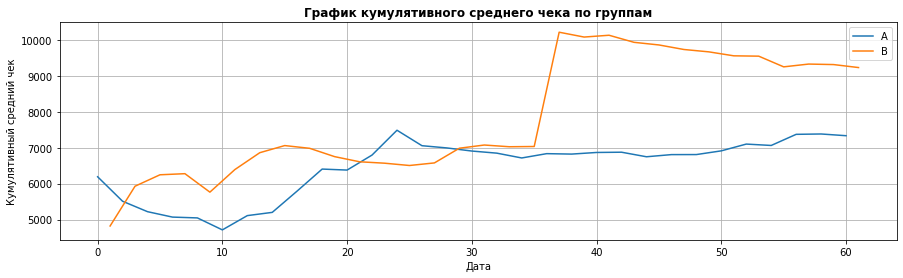

In [11]:
revenue_cum_a = data_cum[data_cum['group'] == 'A'][['date', 'revenue', 'transactions']]
revenue_cum_b = data_cum[data_cum['group'] == 'B'][['date', 'revenue', 'transactions']]

revenue_cum_a['mean_invoice'] = revenue_cum_a['revenue'] / revenue_cum_a['transactions']
revenue_cum_b['mean_invoice'] = revenue_cum_b['revenue'] / revenue_cum_b['transactions']

plt.figure(figsize=(15,4))
plt.grid()
plt.title('График кумулятивного среднего чека по группам', fontsize = 12, weight = 'bold')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.plot(revenue_cum_a['mean_invoice'], label='A')
plt.plot(revenue_cum_b['mean_invoice'], label='B')
plt.legend()

<div class="alert alert-danger">

**Комментарий ревьюера**
    
Кумулятивный средний чек стоит рассчитать, как представлено в теории: кумулятивная выручка делить на кумулятивное количество покупок. Тогда мы в каждый момент времени будем видеть средее значение от того, что было куплено во все дни до рассматриваемого. Сейчас мы видим накопление средних дневных чеков, а не накопленный средний. В итоге график будет иметь немного другой характер.
</div>

<div class="alert alert-info">

**Комментарий студента**
    
Готово. Сделал как в теории.
    
</div>

<div class="alert alert-success">

**Комментарий ревьюера v2**
    
Супер! Теперь мы видим, что на самом деле кумулятивный средний чек группы B ещё восстанавливает своё нормальное положение после всплеска. И он не продолжает расти после всплеска, а снижается.
    
</div>

Как и в случае с кумулятивной выручки видим, что 2019-02-18 имеется большой скачек кумулятивного среднего чека, связанный, по-видимому, с очень дорогой покупкой.

### 3.3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

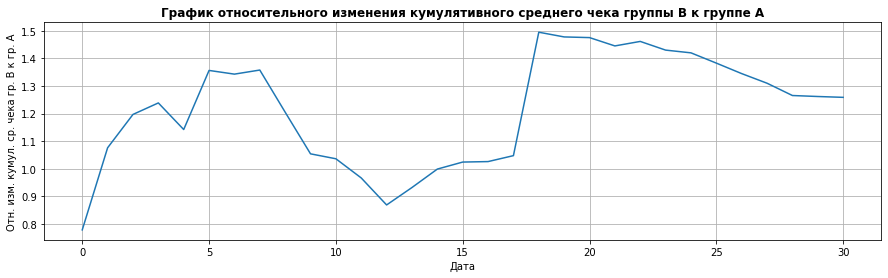

In [12]:
merged_revenue_cum = pd.merge(revenue_cum_a, revenue_cum_b, on='date', suffixes = ['_a', '_b'])
merged_revenue_cum['relativeBA_cum'] = merged_revenue_cum['mean_invoice_b']/merged_revenue_cum['mean_invoice_a']

plt.figure(figsize=(15,4))
plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize = 12, weight = 'bold')
plt.xlabel('Дата')
plt.ylabel('Отн. изм. кумул. ср. чека гр. B к гр. A')
plt.plot(merged_revenue_cum['relativeBA_cum'])

2019-02-18 видим резкий скачек относительного изменения кумулятивного среднего чека группы B к группе A. Предположили, что если не учитывать данный скачек, то в целом график относительного изменения кумулятивного среднего чека группы B к группе A имеет нисходящий тренд.

<div class="alert alert-success">

**Комментарий ревьюера**
    
Ты делаешь верные замечания к графикам выручки и среднего чека. Отлично, что обращаешь внимание на скачок в данных. Но тут я бы хотела подчеркнуть один нюанс.
    
**На резкие скачки выручки могут повлиять, как аномально большие заказы, так и большое количество обычных заказов**. А вот уже по анализу графиков конверсии и среднего чека становится понятнее. Ведь **аномально большие заказы влияют именно на средний чек**, а **большое количество заказов - на конверсию**. Поэтому по среднему чеку ты можешь сделать более точный вывод.
    
То есть по графику с выручкой стоит сделать более широкий вывод о причинах скачка, а уже по графику среднего чека сказать подробнее, в чём было дело. А по конверсии мы видим, что аномалии повлияли только на средний чек, так что вопросов о причинах скачка в выручке не остается.
    
</div>

### 3.4. Построим график кумулятивной конверсии по группам.

In [13]:
visitors_by_date = visitors.pivot_table(index='date', columns='group', values='visitors', aggfunc='sum')
orders_by_date = orders.pivot_table(index='date', columns='group', values='transactionId', aggfunc='nunique')

merged1 = pd.merge(visitors_by_date, orders_by_date, left_on='date', right_on='date').rename(columns={'A_x':'visitorsA', 'B_x':'visitorsB', 'A_y':'transactionsA', 'B_y':'transactionsB'}).cumsum(axis=0)
merged1['conversionA'] = merged1['transactionsA']/merged1['visitorsA']
merged1['conversionB'] = merged1['transactionsB']/merged1['visitorsB'] 

<div class="alert alert-danger">

**Комментарий ревьюера**
    
Конверсия посчитана неверно. Точно ли нужно делить посетителей на покупки?
    
</div>

<div class="alert alert-info">

**Комментарий студента**
    
Пардон. Перепутал числитель и знаменатель. Готово
    
</div>

<div class="alert alert-success">

**Комментарий ревьюера v2**
    
Теперь верно!
    
</div>

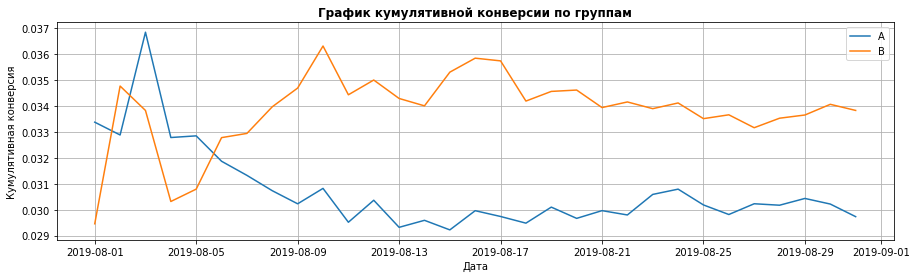

In [14]:
plt.figure(figsize=(15,4))
plt.plot(merged1['conversionA'], label='A')
plt.plot(merged1['conversionB'], label='B')
plt.grid()
plt.title('График кумулятивной конверсии по группам', fontsize = 12, weight = 'bold')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.legend()

Видим, что график кумулятивной конверсии группы B стабилизировался выше группы А.

### 3.5. Построим график относительного изменения кумулятивной конверсии группы B к группе A.

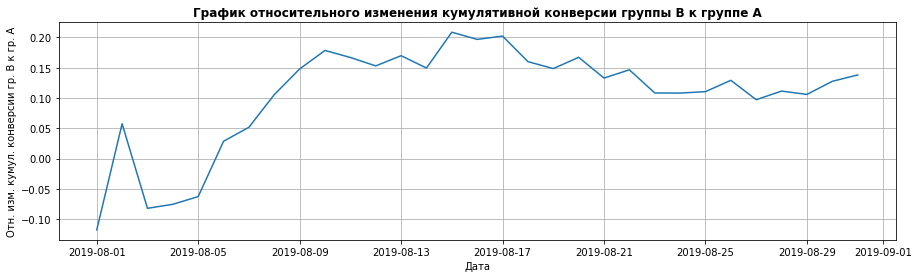

In [15]:
merged1['relative_conversionBA'] = merged1['conversionB']/merged1['conversionA']-1

plt.figure(figsize=(15,4))
plt.grid()
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize = 12, weight = 'bold')
plt.xlabel('Дата')
plt.ylabel('Отн. изм. кумул. конверсии гр. B к гр. A')
plt.plot(merged1['relative_conversionBA'])

Видим, что график относительного изменения кумулятивной конверсии группы B к группе A стабилизировался ниже нуля в диапозоне от -0,17 до -0,08.

<div class="alert alert-warning">

**Комментарий ревьюера v2**
    
Тут надо было исправить вывод в связи с изменениями выше. Это будет несложно сделать, поэтому не стала писать красный комментарий.
    
</div>

### 3.6. Построим точечный график количества заказов по пользователям.

In [16]:
transactions_by_visitors = orders.groupby('visitorId').agg({'transactionId':'count'}).rename(columns={'transactionId':'transactions'})

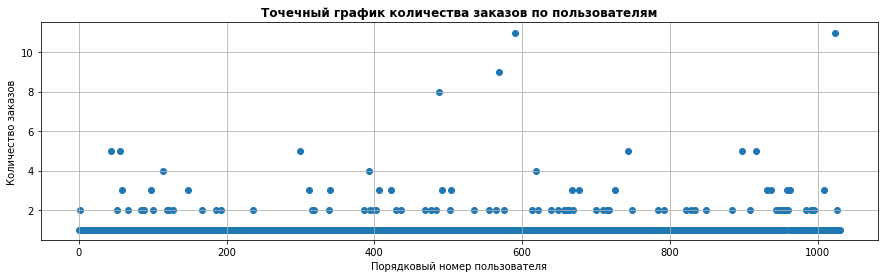

In [17]:
x_values = pd.Series(range(0,len(transactions_by_visitors['transactions'])))
plt.figure(figsize=(15,4))
plt.scatter(x_values, transactions_by_visitors['transactions']) 
plt.title('Точечный график количества заказов по пользователям', fontsize = 12, weight = 'bold')
plt.xlabel('Порядковый номер пользователя')
plt.ylabel('Количество заказов')
plt.grid()

Видим, что большинство пользователей совершают 1-2 заказа. Но что значит "очень много заказов"?

### 3.7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [18]:
np.percentile(transactions_by_visitors['transactions'], [95, 99])

array([2., 4.])

5% пользователей совершило более 2 покупок, и 1% пользователей совершил более 4 покупок.

### 3.8. Построим точечный график стоимостей заказов. Сделайте выводы и предположения.

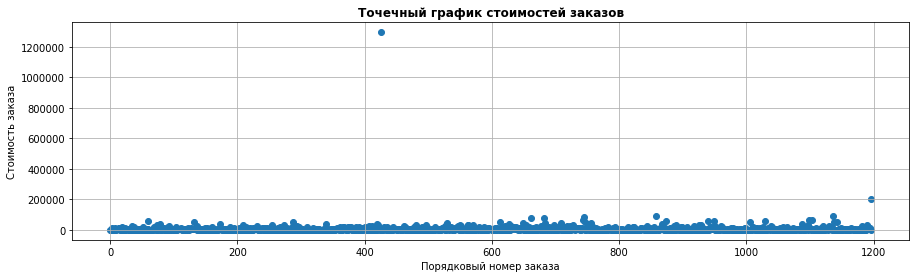

In [19]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,4))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов', fontsize = 12, weight = 'bold')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость заказа')
plt.grid()

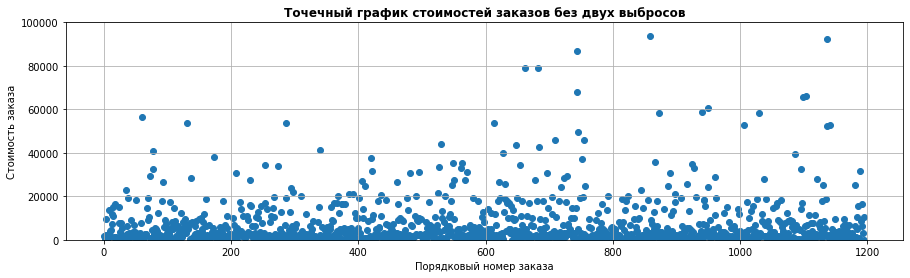

In [20]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,4))
plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'])         
plt.title('Точечный график стоимостей заказов без двух выбросов', fontsize = 12, weight = 'bold')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость заказа')
plt.grid()

Видим, что два заказа сильно выделяется над остальными. Но что значит "очень дорогой заказ"?

### 3.9. Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [21]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

У 5% заказов стоимость выше 28000 у.е., и у 1% заказов стоимость выше 58233.2 у.е.

<div class="alert alert-success">

**Комментарий ревьюера**
    
Комментарии по анализу аномалий корректные.
    
При анализе цены заказов я бы предложила построить ещё один график. Сейчас у тебя представлен общий график, на котором видна вся картина, включая явные выбросы. Этот график абсолютно точно нужен. Но можно было бы ещё добавить один график, ограничив значения по оси Y (чтобы двух явных выбросов не было видно). Тогда выводы по графику стоимости заказов могут быть более точные и детальные. А потом уже анализ перцентилей.
    
</div>

<div class="alert alert-info">

**Комментарий студента**
    
Добавил.
    
</div>

<div class="alert alert-success">

**Комментарий ревьюера v2**
    
Супер, по второму графику действительно видно, что основная часть заказов стоит меньше 58233.2. Можно было это прокомментировать.
    
</div>

### 3.10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [22]:
#создаём датафрейм с заказами группы А
orders_by_users_a = (orders[orders['group'] == 'A']
                     .groupby('visitorId', as_index = False)
                     .agg({'transactionId' : 'nunique'})
                    )
orders_by_users_a.rename(columns = {'visitorId': 'user_id', 'transactionId': 'orders'}, inplace = True)

#создаём датафрейм с заказами группы В
orders_by_users_b = (orders[orders['group'] == 'B']
                     .groupby('visitorId', as_index = False)
                     .agg({'transactionId' : 'nunique'})
                    )
orders_by_users_b.rename(columns = {'visitorId': 'user_id', 'transactionId': 'orders'}, inplace = True)

In [23]:
#создаём датафрейм с количеством посетителей из группы А в каждый день
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.rename(columns = {'visitors': 'visitors_per_date_a'}, inplace = True)

#создаём датафрейм с количеством посетителей из группы В в каждый день
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.rename(columns = {'visitors': 'visitors_per_date_b'}, inplace = True)

In [24]:
visitors_daily = visitors_a_daily.merge(visitors_b_daily, on = 'date')

In [25]:
#выборки для групп
#сцепляем две series: одна с количеством заказов для пользователей, которые совершили заказ 
#и вторая с 0 (для тех, кто не совершил заказ, а их: число посетителей - число купивших)

sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index = np.arange(visitors_daily['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name = 'orders')], axis = 0)

sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index = np.arange(visitors_daily['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name = 'orders')], axis = 0)

In [26]:
#функция принимает 2 объекта series и название параметра, по которому мы проверяем гипотезу
#возвращает результаты гипотезы мэна-уитни
def test(sample_a, sample_b, parameter):
    pvalue = stats.mannwhitneyu(sample_a, sample_b, alternative = 'two-sided')[1]
    alpha = 0.05

    print('p-значение: {0:.3f}'.format(pvalue))

    if (pvalue < alpha):
        print(f"Отвергаем нулевую гипотезу: различия в {parameter} есть")
    else:
        print(f'''Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в {parameter} нет''')

    print("Относительный проигрыш/выигрыш группы B равен {0:.1%}".format(sample_b.mean() / sample_a.mean() - 1))

<div class="alert alert-danger">

**Комментарий ревьюера**
    
Есть у реализации метода Манна-Уитни в python одна особенность: его базовые настройки в python не предполагают проверку двухсторонней гипотезы, а это не соответствует гипотезам, проверяемым в проекте. Для корректной работы метода необходимо задать его параметр **alternative = 'two-sided'** во всех случаях.
    
Пока в теории этот момент не исправлен. Но среди преподавателей и ревьюеров мы уже договорились, что будем обращать на это внимание, чтобы студенты уже получали максимально актуальную информацию. Поэтому давай внесём это изменение, чтобы закрепить эту особенность и корректно всё оформить.
    
</div>

<div class="alert alert-info">

**Комментарий студента**
    
Параметр задан.
    
</div>

<div class="alert alert-success">

**Комментарий ревьюера v2**
    
Отлично!
</div>

Нулевая гипотеза: конверсия в группах А и В равна

Альтернативная гипотеза: конверсия в группах А и В различна

<div class="alert alert-success">

**Комментарий ревьюера**
    
Гипотезы сформулированы корректно. 
    
</div>

In [27]:
test(sample_a, sample_b, 'конверсии')

p-значение: 0.017
Отвергаем нулевую гипотезу: различия в конверсии есть
Относительный проигрыш/выигрыш группы B равен 13.8%


Вывод: присутствует статистическая значимость различий в конверсии между группами по «сырым» данным. Конверия группы В выше на 13.8%. 

### 3.11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Нулевая гипотеза: размер среднего чека в группах А и В одинаков

Альтернативная гипотеза: размер среднего чека в группах А и В оличается

In [28]:
revenue_a = orders[orders['group'] == 'A']['revenue']
revenue_b = orders[orders['group'] == 'B']['revenue']

test(revenue_a, revenue_b, 'среднем чеке')

p-значение: 0.729
Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в среднем чеке нет
Относительный проигрыш/выигрыш группы B равен 25.9%


Вывод: отсутствует статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. Однако, средний чек группы В выше на 25.9%. Посчитаем тоже самое по "очищенным данным".

### 3.12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

In [29]:
abnormal_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 2]['user_id'], orders_by_users_b[orders_by_users_b['orders'] > 2]['user_id']], axis = 0)
abnormal_revenue = orders[orders['revenue'] > 28000]['visitorId']

abnormal_users = (pd.concat([abnormal_orders, abnormal_revenue], axis = 0)
                  .drop_duplicates()
                  .sort_values()
                 )

In [30]:
#выборки для "чистых" групп
#сцепляем две series: одна с количеством заказов для НЕ аномальных пользователей, которые совершили заказ
#и вторая с 0 (для тех, кто не совершил заказ, а их: число посетителей - число купивших)

clean_sample_a = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))]['orders'], pd.Series(0, index = np.arange(visitors_daily['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name = 'orders')], axis = 0)

clean_sample_b = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))]['orders'], pd.Series(0, index = np.arange(visitors_daily['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name = 'orders')], axis = 0)

Нулевая гипотеза: конверсия в "чистых" группах А и В равна

Альтернативная гипотеза: конверсия в "чистых" группах А и В различна

In [31]:
test(clean_sample_a, clean_sample_b, 'конверсии по "чистым" данным')

p-значение: 0.013
Отвергаем нулевую гипотезу: различия в конверсии по "чистым" данным есть
Относительный проигрыш/выигрыш группы B равен 17.3%


Вывод: присутствует статистическая значимость различий в конверсии между группами по «чистым» данным. Конверия группы В выше на 17.3%.

### 3.13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [32]:
clean_revenue_a = (orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])

clean_revenue_b = (orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])

Нулевая гипотеза: размер среднего чека в "чистых" группах А и В равен

Альтернативная гипотеза: размер среднего чека в "чистых" группах А и В различен

In [33]:
test(clean_revenue_a, clean_revenue_b, 'среднем чеке по "чистым" данным')

p-значение: 0.738
Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в среднем чеке по "чистым" данным нет
Относительный проигрыш/выигрыш группы B равен -2.0%


Вывод: отсутствует статистическая значимость различий в среднем чеке заказа между группами по «чистым» данным. Средний чек группы В ниже на 2%.

<div class="alert alert-success">

**Комментарий ревьюера**
    
В целом, твои комментарии по тестам верные.
    
Хочу обратить внимание, что здесь видна **парадоксальность результата для среднего чека по сырым данным**: разница большая, но статистически не значима. Это обусловлено аномалиями, к которым критерий Манна-Уитни не чувствителен. Когда ты посчитаешь относительное изменение среднего чека на очищенных данных, то увидишь: относительная разница в среднем чеке очевидно мала, что подтверждает тест. Было бы здорово сделать на этом акцент в выводах.

На будущее я бы советовала **автоматизировать тесты**. Для каждой проверки ты рассчитываешь p-value и различие в средних. Это можно оформить в виде функции и вызывать её 4 раза.
    
</div>

### 3.14. Вывод

Был проведён анализ результатов A/B-теста: 
- построены графики конверсии, среднего чека для каждой из групп и относительного изменения по этим параметрам,
- найдены границы для определения выбивающихся данных,
- построены графики конверсии и среднего чека по группам уже на очищенных данных,
- для "сырых" и "чистых" данных посчитана статистическая значимость различий конверсии и среднего чека.

<div class="alert alert-info">
    
## Общий вывод

Исходя из подготовленного списока гипотез для увеличения выручки приоритизировали гипотезы фреймворками ICE и RICE. Так как в нашем случае более подходящим является RICE, для A/B-теста выбрали гипотезу №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". 

Запустили A/B-тест и получили результаты.

Проанализировали результаты конверсии и среднего чека:
- Есть статистически значимое различие по конверсии между группами и по «сырым», и по данным после фильтрации - группа B имеет лучшую конверсию. График конверсии стабилизировался.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. График не стабилизировался, и для получения окончательных результатов по среднему чеку требуется продолжить A/B-тест.

В целом предлагаем принять A/B-тест успешным и остановаить его, так как получили однозначные результаты о повышении конверсии на  17.3% по "чистым данным".

<div class="alert alert-success">

**Комментарий ревьюера - резюме**
    
Нужно обратить внимание на следующие места:
    
1. Предобработка
2. Графики кумулятивного среднего чека и конверсии
3. Функция для расчёта критерия Манна-Уитни
    
В остальном проект отличный. Всё выполнено последовательно, структурировано, достаточно промежуточных комментариев и выводов.
    
Думаю, ты легко внесёшь нужные изменения. Если будут вопросы, с радостью на них отвечу. Буду ждать работу вновь :)
    
</div>

<div class="alert alert-info">

**Комментарий студента**
    
Спасибо большое!
    
</div>

<div class="alert alert-success">

**Комментарий ревьюера v2 - резюме**
    
Сейчас проект завершён, замечаний больше нет :) Удачи в следующих работах!
    
</div>